In [1]:
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils_dataset import *
from utils_sampling import *
from utils_models import *
from funcs_model_predictions import *
from funcs_model_fit_evaluate import *

In [2]:
datasetName = 'takahashi2016roesch2009burton2018Valid'
dataValid = pd.read_csv('data/' + datasetName + '.csv')
NRats = dataValid['rat'].nunique()

In [3]:
def transformation(x, bounds):
    lb = bounds[0]
    ub = bounds[1]
    if (np.isinf(lb) & np.isinf(ub)):
        return x
    else:
        return phi_approx(x)*(ub-lb) + lb

In [4]:
modelName = 'hybridValue_full'

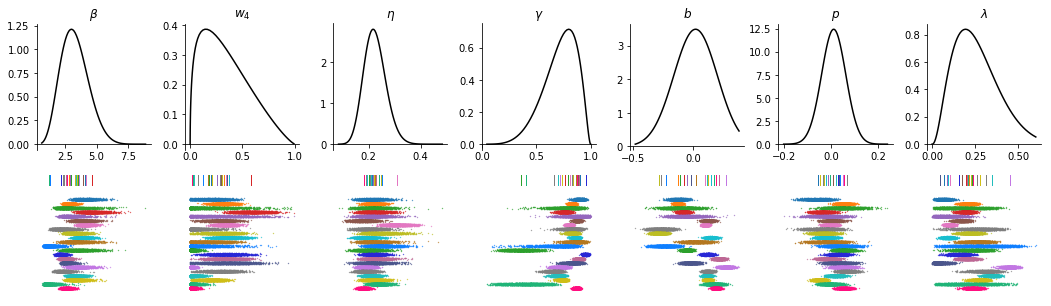

In [5]:
allSamples = pd.read_csv('model_fits/'+datasetName+'_'+modelName+'_allSamples.csv')
posterior = allSamples2posterior(allSamples, modelInfo[modelName], samplingInfo)
parNames = modelInfo[modelName]['parNames']
NPars = modelInfo[modelName]['Npars']
parBounds = modelInfo[modelName]['parBounds']
parLabels = {
    'beta': r'$\beta$',
    'w4': r'$w_4$',
    'eta': r'$\eta$',
    'gamma': r'$\gamma$',
    'sb': r'$b$',
    'pers': r'$p$',
    'lapse': r'$\lambda$'
}


## plot group-level distribution (curve): N(mu_pr, sigma^2) put through Phi_approx function, where mu_pr and sigma are averages over samples
# with individual samples (tiny points) and individual means (points) overlaid
fig, axes = plt.subplots(2, NPars, figsize=(18,5))
for iPar in np.arange(NPars):
    # plot group-level parameters
    axg = axes[0,iPar]
    # parameters for group-level gaussian (before transformation)
    groupMean = np.mean(posterior['mu_pr'][:,iPar])
    groupStd = np.mean(posterior['sigma'][:,iPar])
    # get a reasonable range of x
    xmin = np.min((np.tile(posterior['mu_pr'][:,iPar],(NRats,1)).T+posterior[parNames[iPar]+'_samp']*np.tile(posterior['sigma'][:,iPar],(NRats,1)).T).flatten())
    xmax = np.max((np.tile(posterior['mu_pr'][:,iPar],(NRats,1)).T+posterior[parNames[iPar]+'_samp']*np.tile(posterior['sigma'][:,iPar],(NRats,1)).T).flatten())
    xvalues = np.arange(xmin,xmax,(xmax-xmin)/100)
    # plot the group-level distribution after transformation
    axg.plot(transformation(xvalues, parBounds[iPar]), sp.stats.norm.pdf(xvalues,groupMean,groupStd), color='k')
    # ax settings
    axg.set_title(parLabels[parNames[iPar]])
    axg.spines['bottom'].set_position('zero')
    axg.spines['top'].set_visible(False)
    axg.spines['right'].set_visible(False)
    
    # plot individual parameters
    axi = axes[1,iPar]
    span = np.max(sp.stats.norm.pdf(xvalues,groupMean,groupStd))
    Nsamples = (samplingInfo['samples']-samplingInfo['warmup'])*samplingInfo['chains']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for iSub in ratOrder:
        from matplotlib.colors import to_rgb
        color = np.array(to_rgb(colors[iSub%len(colors)]))
        if np.floor(iSub/len(colors)) == 1:
            color[0],color[2] = color[2],color[0]
        elif np.floor(iSub/len(colors)) == 2:
            color[1],color[2] = color[2],color[1]
        x = posterior[parNames[iPar]][:,ratOrder[iSub]]
        axi.plot([np.mean(x), np.mean(x)], [-span/4.5, -span/3], color=color, lineWidth=1)
        axi.scatter(x, -span/2.2 + np.random.uniform(-span*(iSub*2+2)/(NRats*2),-span*(iSub*2+1)/(NRats*2),Nsamples), s=0.1, color=color)
    # ax settings
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.set(xticks=[], yticks=[])

plt.subplots_adjust(hspace=0.15, wspace=0.3)